# Book Recommendation System (Collaborative Filtering)

**Overview:**  
This project builds an item-based collaborative filtering system to recommend books to users based on their past ratings. The system uses **Pearson similarity** to measure how similar books are based on overlapping user ratings.

**Tech Stack:**  
- Python 3.12 / PySpark  
- Google Colab for data processing  
- CSV datasets for books and ratings  

**Features:**  
1. Data cleaning and preprocessing (removing invalid/duplicate ratings, cleaning ISBNs and metadata)  
2. Item-item similarity calculation using Pearson correlation  
3. Function to recommend top-N similar books for any given book  
4. Visualization of similarity distributions  
5. Optional user-centric recommendations (can be added later, idk)

## Data Upload

_Because it’s large, we upload it at the top of the notebook every session (Github didnt accept it because its >50MB)._

In [1]:
# Upload the books dataset manually
from google.colab import files
import io

uploaded = files.upload()

# Get the uploaded file name
csv_filename = next(iter(uploaded))
print(f"Uploaded: {csv_filename}")


Saving Books.csv to Books (1).csv
Uploaded: Books (1).csv


---
## Spark Setup & Load Dataset

We use Apache Spark; Spark lets you work with large datasets efficiently by distributing computation across multiple machines or CPU cores. It processes millions of rows faster than regular Python (Pandas)

### Spark Initialization

In [2]:
!pip install pyspark --quiet #install pyspark in colab (with suppression)

from pyspark.sql import SparkSession # the entry point to spark functions


# Spark config
spark = SparkSession.builder \
    .appName("BookRecommendationCF") \
    .getOrCreate()

spark


### Load the Dataset into Spark

In [3]:
# Load the uploaded CSV into a Spark DataFrame
ratings_raw = spark.read.csv( # this is the original dataset
    csv_filename,
    header=True,
    inferSchema=True, # auto detect types
    escape="\"",
    multiLine=True # important, otherwise the loading will be corrupt
)

print("Rows:", ratings_raw.count())
ratings_raw.printSchema()
ratings_raw.show(5, truncate=False)


Rows: 374381
root
 |-- _c0: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- age: double (nullable = true)
 |-- isbn: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- book_title: string (nullable = true)
 |-- book_author: string (nullable = true)
 |-- year_of_publication: integer (nullable = true)
 |-- publisher: string (nullable = true)
 |-- img_s: string (nullable = true)
 |-- img_m: string (nullable = true)
 |-- img_l: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)

+---+-------+-------------------------+-----------+---------+------+-------------------+--------------------+-------------------+-----------------------+------------------------------------------------------------+---------------------

Some notes:
- `rating`: 0 means no rating
- `isbn`: is stored as String, bec some isbn include hyphens, and if it wasn't a string, leading zeros may be removed.

### Quick Inspection

In [4]:
# Num of distinct users and books
print("Unique users:", ratings_raw.select("user_id").distinct().count())
print("Unique ISBNs:", ratings_raw.select("isbn").distinct().count())

# Detect potential issues early
ratings_raw.describe(['user_id', 'age', 'isbn', 'state', 'Category']).show()


Unique users: 28019
Unique ISBNs: 2149
+-------+------------------+------------------+--------------------+--------------+--------------------+
|summary|           user_id|               age|                isbn|         state|            Category|
+-------+------------------+------------------+--------------------+--------------+--------------------+
|  count|            101863|            101863|              101863|        101456|              101863|
|   mean|136443.63949618605|35.704363173426806|5.0556559520462567E8|          NULL|                 9.0|
| stddev| 82051.71966617579| 9.992327482294987|4.9504786308833826E8|          NULL|                 0.0|
|    min|                 2|               5.0|          000636988X|     &#322;���|                   9|
|    max|            278851|              99.0|          9997522052|��sterg��tland|['Young Adult Non...|
+-------+------------------+------------------+--------------------+--------------+--------------------+



Notes:
- num of distinct ids = number or records (expected)
- num of isbn = number of records (expected)
- Some isbns have non-numeric chars, they must be numeric strings for matching.

---
## Data Cleaning / Preparation

### Drop unneeded columns

some features we actually dont need, like the `_c0`, location info, `age`, `images`, `language`, `summary`.

keeping them will waste memory, slow down computations, and make the notebook unreadable.

and some data will distory the similarity calcs, like the 0 rating.

also we remove inactive users and rarely rated books bec the Pearson correlation needs overlap.

### Drop uneeded features (columns)

In [5]:
# Keep only columns needed for ratings and minimal metadata
ratings_cols = ["user_id", "isbn", "rating"]
books_cols = ["isbn", "book_title", "book_author"]

ratings_df = ratings_raw.select(ratings_cols) # new dataFrame
books_df = ratings_raw.select(books_cols).dropDuplicates(["isbn"])

print("[a] Ratings DF shape:", ratings_df.count(), "rows")
print("[b] Books DF shape:", books_df.count(), "unique books")

[a] Ratings DF shape: 374381 rows
[b] Books DF shape: 2149 unique books


_You have [a] ratings spread across [b] books._

### Clean ISBNs

Remove non-numeric chars, and remove empty ones (best done by regex)

In [6]:
from pyspark.sql.functions import regexp_replace, col

print("Before ISBN cleaning:", ratings_df.count(), "ratings,", books_df.count(), "books")

# Remove non-numeric characters from ISBN
ratings_df = ratings_df.withColumn("isbn", regexp_replace(col("isbn"), "[^0-9]", ""))
books_df = books_df.withColumn("isbn", regexp_replace(col("isbn"), "[^0-9]", ""))

# Drop rows where ISBN is empty after cleaning
ratings_df = ratings_df.filter(col("isbn") != "")
books_df = books_df.filter(col("isbn") != "")

print("After ISBN cleaning:", ratings_df.count(), "ratings,", books_df.count(), "books")



Before ISBN cleaning: 374381 ratings, 2149 books
After ISBN cleaning: 101863 ratings, 2148 books


### Remove zero or invalid ratings

In [7]:
ratings_df = ratings_df.filter((col("rating") > 0) & (col("rating") <= 10))
print("Ratings after removing zeros/invalid:", ratings_df.count())


Ratings after removing zeros/invalid: 42659


### Filter active users and books (≥5 ratings)

_Active users/book are those that exist more than 4 times in the dataset._

In [8]:
from pyspark.sql.functions import count

# Active users: ≥5 ratings
active_users = ratings_df.groupBy("user_id").agg(count("isbn").alias("num_ratings")) \
                         .filter(col("num_ratings") >= 5) \
                         .select("user_id")

ratings_df = ratings_df.join(active_users, on="user_id", how="inner")

# Active books: ≥5 ratings
active_books = ratings_df.groupBy("isbn").agg(count("user_id").alias("num_ratings")) \
                         .filter(col("num_ratings") >= 5) \
                         .select("isbn")

ratings_df = ratings_df.join(active_books, on="isbn", how="inner")

print("Ratings after filtering active users/books:", ratings_df.count())


Ratings after filtering active users/books: 16623


### Clean titles and authors

In [9]:
from pyspark.sql.functions import when, trim

books_df = books_df.withColumn("book_title", trim(col("book_title")))
books_df = books_df.withColumn("book_title", when(col("book_title") == "", "Unknown Title").otherwise(col("book_title")))

books_df = books_df.withColumn("book_author", trim(col("book_author")))
books_df = books_df.withColumn("book_author", when(col("book_author") == "", "Unknown Author").otherwise(col("book_author")))

# Keep only books present in cleaned ratings
books_df = books_df.join(ratings_df.select("isbn").distinct(), on="isbn", how="inner")

print("After cleaning titles/authors:", books_df.count(), "books")



After cleaning titles/authors: 761 books


### Remove duplicate ratings per user/book

We want only **one rating per user per book**.    
We keep highest rating. (or using timestamp is better)

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Keep only the highest rating if duplicates exist
window = Window.partitionBy("user_id", "isbn").orderBy(col("rating").desc())

ratings_df = ratings_df.withColumn("row_num", row_number().over(window)) \
                       .filter(col("row_num") == 1) \
                       .drop("row_num")

print("After removing duplicate ratings:", ratings_df.count(), "ratings")



After removing duplicate ratings: 16623 ratings


### Cleaning Result

In [11]:
print("Final ratings:", ratings_df.count())
print("Final books:", books_df.count())
print("Active users:", active_users.count())


Final ratings: 16623
Final books: 761
Active users: 1785


---
## Pearson Similarity & Recommendations

_Spark does not have a built-in Pearson similarity function, so we compute it manually on user rating pairs._

### Prepare User Rating Pairs

**Goal**: For every pair of books rated by the same user, compute:

- rating for book A
- rating for book B
-
Creating pairs of books that were rated by the same user. These pairs are needed because Pearson similarity **requires** comparing two books across the ratings of the users who rated both.   

A self-join matches every book a user rated with every other book they rated. It generates all book pairs per user, and the `isbn_a < isbn_b` condition ensures each pair is unique (no duplicates like A–B and B–A).

In [12]:
from pyspark.sql.functions import col

# Create user-book pairs: book A & book B for every user
rating_pairs = ratings_df.alias("a") \
    .join(ratings_df.alias("b"),
          (col("a.user_id") == col("b.user_id")) & (col("a.isbn") < col("b.isbn"))
    ) \
    .select(
        col("a.user_id").alias("user_id"),
        col("a.isbn").alias("isbn_a"),
        col("b.isbn").alias("isbn_b"),
        col("a.rating").alias("rating_a"),
        col("b.rating").alias("rating_b")
    )

rating_pairs.show(5)


+-------+---------+---------+--------+--------+
|user_id|   isbn_a|   isbn_b|rating_a|rating_b|
+-------+---------+---------+--------+--------+
|     99|312252617|451166892|       8|       3|
|     99|312252617|446677450|       8|      10|
|     99|312252617|312261594|       8|       8|
|     99|312261594|451166892|       8|       3|
|     99|312261594|446677450|       8|      10|
+-------+---------+---------+--------+--------+
only showing top 5 rows



### Compute Pearson Components

#### Step 1 — Compute average rating per ISBN

_just get the avg rating for each book_

In [13]:
from pyspark.sql.functions import avg

# Compute average rating for each book (isbn)
avg_ratings = ratings_df.groupBy("isbn").agg(
    avg("rating").alias("avg_rating")  # compute mean rating for each book
)


print("Sample average ratings per book:")
avg_ratings.show(5, truncate=False)

Sample average ratings per book:
+---------+-----------------+
|isbn     |avg_rating       |
+---------+-----------------+
|312252617|8.0              |
|312261594|6.333333333333333|
|446677450|7.8              |
|451166892|8.515151515151516|
|446608653|7.625            |
+---------+-----------------+
only showing top 5 rows



#### Step 2 — Join averages with rating pairs

_adding the avg rating of each book to the `rating_pairs` dataFrame we created earlier_    
now we have a dataFrame with these columns: `user_id, isbn_a, isbn_b, rating_a, rating_b, avg_a, avg_b`

In [14]:
print("Before adding the sample rating pairs with averages:")
rating_pairs.show(5)

# Join averages to rating_pairs for both isbn_a and isbn_b
rating_pairs = rating_pairs \
    .join(avg_ratings.withColumnRenamed("isbn", "isbn_a").withColumnRenamed("avg_rating", "avg_a"), on="isbn_a") \
    .join(avg_ratings.withColumnRenamed("isbn", "isbn_b").withColumnRenamed("avg_rating", "avg_b"), on="isbn_b")

# 1. we overwrite the rating_pairs
# 2. we RENAME isbn -> isbn_a in avg_ratings, and also avg_rating -> avg_a.
#   And then Spark can join bec both tables now have the same column "isbn_a"
# 3. Same thing, but now for the second book.

print("Sample rating pairs with averages:")
rating_pairs.show(5, truncate=False)



Before adding the sample rating pairs with averages:
+-------+---------+---------+--------+--------+
|user_id|   isbn_a|   isbn_b|rating_a|rating_b|
+-------+---------+---------+--------+--------+
|     99|312252617|451166892|       8|       3|
|     99|312252617|446677450|       8|      10|
|     99|312252617|312261594|       8|       8|
|     99|312261594|451166892|       8|       3|
|     99|312261594|446677450|       8|      10|
+-------+---------+---------+--------+--------+
only showing top 5 rows

Sample rating pairs with averages:
+---------+---------+-------+--------+--------+-----------------+-----------------+
|isbn_b   |isbn_a   |user_id|rating_a|rating_b|avg_a            |avg_b            |
+---------+---------+-------+--------+--------+-----------------+-----------------+
|451166892|312252617|99     |8       |3       |8.0              |8.515151515151516|
|446677450|312252617|99     |8       |10      |8.0              |7.8              |
|312261594|312252617|99     |8     

#### Step 3 — Compute numerator and denominator

_we simply calculate the top part (numerator) of the equation and the bottom part (denominator)_

In [15]:
from pyspark.sql.functions import pow, sum as spark_sum, sqrt, count

pearson_components = rating_pairs.groupBy("isbn_a", "isbn_b").agg(
    spark_sum((col("rating_a") - col("avg_a")) * (col("rating_b") - col("avg_b"))).alias("numerator"), # numerator
    sqrt(spark_sum(pow(col("rating_a") - col("avg_a"), 2))).alias("den_a"), # denominator a (left side of the bottom part)
    sqrt(spark_sum(pow(col("rating_b") - col("avg_b"), 2))).alias("den_b"), # denominator b (right side of the bottom part)
    count("user_id").alias("num_common_users") # how many users rated both books
)

print("Computed numerator, denominator, and number of common users for each book pair.")
pearson_components.show(5, truncate=False)


Computed numerator, denominator, and number of common users for each book pair.
+---------+---------+--------------------+------------------+------------------+----------------+
|isbn_a   |isbn_b   |numerator           |den_a             |den_b             |num_common_users|
+---------+---------+--------------------+------------------+------------------+----------------+
|037582345|60976977 |0.5                 |0.5               |1.0               |1               |
|037582345|60934700 |-0.40000000000000036|0.5               |0.8000000000000007|1               |
|373226144|399146431|-1.6231884057971002 |2.333333333333333 |0.695652173913043 |1               |
|055357695|689710879|-1.0909090909090917 |0.5454545454545459|2.0               |1               |
|316779423|385470819|2.083333333333335   |2.5               |0.8333333333333339|1               |
+---------+---------+--------------------+------------------+------------------+----------------+
only showing top 5 rows



#### Step 4 — Compute Pearson similarity

In [16]:
from pyspark.sql.functions import when

pearson_df = pearson_components.withColumn(
    "pearson",
    when((col("den_a") == 0) | (col("den_b") == 0), 0)
    .otherwise(col("numerator") / (col("den_a") * col("den_b")))
)

print("Pearson similarity computed for book pairs:")
pearson_df.where("num_common_users > 5").show(5, truncate=False) # num of people rated more than 5 for better understanding


Pearson similarity computed for book pairs:
+---------+---------+-------------------+------------------+------------------+----------------+--------------------+
|isbn_a   |isbn_b   |numerator          |den_a             |den_b             |num_common_users|pearson             |
+---------+---------+-------------------+------------------+------------------+----------------+--------------------+
|014025448|64407667 |0.1357142857142831 |3.071441029875066 |7.009468814484054 |6               |0.006303739762977763|
|142001740|385721420|0.18189368770764047|2.1211291216415953|2.810330796129429 |8               |0.03051357400711659 |
|044021145|446310786|13.222222222222225 |6.29226450434123  |7.14142842854285  |12              |0.29424723693030397 |
|038572179|743418174|-5.359330759330755 |2.7139849457420144|2.5148854791615496|7               |-0.7852083574267767 |
|014028009|440226430|7.891725352112679  |7.360189293167917 |5.547226221274918 |11              |0.19328898319190943 |
+---------+-

Some notes:
- If only 1-2 users rated both books -> similarity is unreliable
- For numerator:
    - Large positive numerator -> users gave similar rating patterns
    - Large negative numerator -> users had opposite opinions

- For denominator:
    - Low number -> ratings are close to average (not very informative)
    - High number -> ratings vary a lot (more informative)

Pearson interpretation:
- 1.0 -> perfectly similar
- 0.5 -> moderately similar
- 0.0 -> no relationship
- -0.5 -> moderately opposite
- -1.0 -> completely opposite

Example row:
```
044021145 | 446310786 | numerator=13.62 | den_a=6.60 | den_b=7.16 | num_common_users=14 | pearson=0.2879
```

- 14 users rated both books
- Their rating patterns for both books were moderately similar (Pearson ≈ 0.29)
- Not super strong, but noticeable positive relationship

Meaning:
"People who liked book A also kinda liked book B."
Not super strong, but something.



---
## Book Similarity Recommendations

_before building the function, we perform some necessary cleaning, so we keep only useful columns and filter out low overlapping pairs (bec pearson is unreliable for low overlapping books_

In [17]:
# Keep only useful columns and filter low-overlap pairs
similarity_df = pearson_df.select(
    "isbn_a", "isbn_b", "pearson", "num_common_users"
).filter(col("num_common_users") >= 3)

print("Similarity pairs after filtering:")
similarity_df.show(5, truncate=False)


Similarity pairs after filtering:
+---------+---------+--------------------+----------------+
|isbn_a   |isbn_b   |pearson             |num_common_users|
+---------+---------+--------------------+----------------+
|014025448|64407667 |0.006303739762977763|6               |
|375705856|60392452 |-0.25225843168897194|3               |
|142001740|385721420|0.03051357400711659 |8               |
|60085444 |743418174|-0.5538529387480751 |3               |
|312978383|684874350|0.4497091445375675  |4               |
+---------+---------+--------------------+----------------+
only showing top 5 rows



_now here is the recommendation function_

In [18]:
def recommend_similar_books(target_isbn, top_n=5):
    """
    Return top-N similar books for a given ISBN based on Pearson similarity.
    """

    # Similarities where the target book is isbn_a
    sim_a = similarity_df.filter(col("isbn_a") == target_isbn) \
                         .select(
                             col("isbn_b").alias("isbn"),
                             "pearson"
                         )

    # Similarities where the target book is isbn_b
    sim_b = similarity_df.filter(col("isbn_b") == target_isbn) \
                         .select(
                             col("isbn_a").alias("isbn"),
                             "pearson"
                         )

    # So by now we got both sides (A-B) and (B-A)

    # Combine both directions
    sims = sim_a.union(sim_b)

    if sims.count() == 0:
        print("No similar books found (not enough data).")  # if no similar books are found
        return None

    # Sort and get top-N highest similarity scores
    top_sims = sims.orderBy(col("pearson").desc()).limit(top_n)


    # Join to add book titles and authors
    recommendations = top_sims.join(books_df, on="isbn", how="left")  # add metdata

    return recommendations


---
## Testing and saving

In [19]:
# Pick 2 example books from cleaned books_df
sample_books = books_df.limit(2).collect()

for book in sample_books:
    isbn = book['isbn']
    title = book['book_title']
    print(f"\nTop recommendations for '{title}' (ISBN: {isbn}):")

    recs = recommend_similar_books(isbn, top_n=5)

    if recs:
        # Show ISBN, Title, Author, Pearson score
        recs.select("isbn", "book_title", "book_author", "pearson").show(truncate=False)



Top recommendations for 'Chocolat' (ISBN: 014100018):
+---------+----------------------------------------------------------+----------------+------------------+
|isbn     |book_title                                                |book_author     |pearson           |
+---------+----------------------------------------------------------+----------------+------------------+
|067976402|Snow Falling on Cedars                                    |David Guterson  |0.9555241905400442|
|345378490|Congo                                                     |Michael Crichton|0.9884955026712443|
|446601241|Kiss the Girls                                            |James Patterson |0.9524570388294568|
|446606812|Message in a Bottle                                       |Nicholas Sparks |0.9487884068418463|
|60987103 |Wicked: The Life and Times of the Wicked Witch of the West|Gregory Maguire |0.9914538517367686|
+---------+----------------------------------------------------------+----------------+--

_saving essential outputs_

In [20]:
# Save book similarity pairs (item-item) for GitHub
similarity_df.toPandas().to_csv("book_similarity.csv", index=False)
print("Saved book similarity pairs to 'book_similarity.csv'")

# Save example recommendations for the first sample book
if sample_books:
    first_isbn = sample_books[0]['isbn']
    recs = recommend_similar_books(first_isbn, top_n=5)
    if recs:
        recs.toPandas().to_csv("example_recommendations.csv", index=False)
        print("Saved example recommendations to 'example_recommendations.csv'")


Saved book similarity pairs to 'book_similarity.csv'
Saved example recommendations to 'example_recommendations.csv'


---
## Visualizations

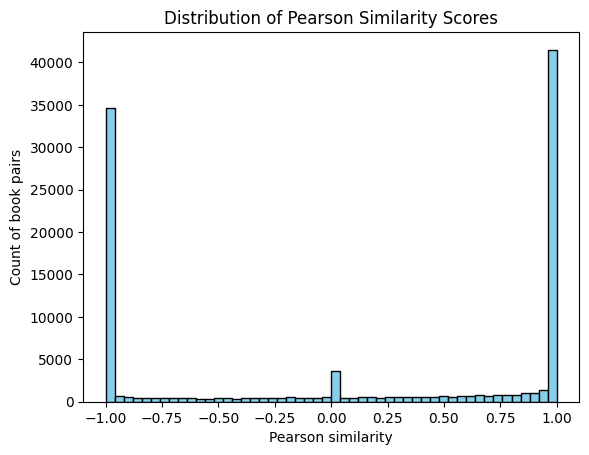

In [21]:
import matplotlib.pyplot as plt

# Histogram of Pearson similarity scores
pearson_scores = pearson_df.select("pearson").rdd.flatMap(lambda x: x).collect()

plt.hist(pearson_scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Pearson Similarity Scores")
plt.xlabel("Pearson similarity")
plt.ylabel("Count of book pairs")
plt.show()


---
## Conclusion

- Successfully built an **item-based collaborative filtering system** using Spark.  
- Learned how to **clean large datasets**, handle duplicates, and compute Pearson similarity.  
- Built a **recommendation function** that can suggest books to users based on other similar books.  
- Optional next steps: user-centric recommendations, improving performance with Spark caching, or adding new similarity metrics.
